# word_to_vector

sentence -> tokenization -> cleansing, stemming -> encoding -> sorting -> padding/similarity


### 0) 환경 설정
* tokenizer (한글 형태소 분석기) 설치
* 한글 글꼴 설치
* 사전 학습을 위한 한글 말뭉치 패키지 설치
* 설치 후 런타임 재시작 필요

In [ ]:
# tokenizer
!pip install konlpy


# hangul font
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf


# Korpora install
!pip install Korpora

# !pip install gensim==3.8.3  # fail
# !pip install gensim

# debug mode set up
!pip install -Uqq ipdb
## 사용법
# import ipdb  #; ipdb.set_trace()  ipdb > pdb
# %pdb on

## 환경데이터 word2vec


### 1) 파일 로드
* mac에서 저장한 xlsx 파일은 읽지 못함. xls파일로 저장하여 로드할 것
* 데이터 전처리 (한글만 남기는 처리)
* 라벨 인코딩 (문자는 처리하지 못하여 int로 변경)

In [ ]:
#!pwd
#!ls -al
#!ls -al /content/drive/MyDrive/Colab\ Notebooks/nlp/kyobonlp
#MyDrive/Colab\ Notebooks/nlp/kyobonlp/trainingdata.xlsx

/content
total 152310
drwx------ 2 root root     4096 Dec 12 01:36 .git
-rw------- 1 root root 50697568 Dec 21  2016 ko.bin
-rw------- 1 root root 85362829 Dec 21  2016 ko.tsv
-rw------- 1 root root    91648 Dec 21 08:06 kyobodata.xls
-rw------- 1 root root 19515078 Dec 14 10:36 ratings.txt
-rw------- 1 root root       38 Dec 12 01:36 README.md
-rw------- 1 root root    76800 Dec 21 07:10 test_set.xls
-rw------- 1 root root    40214 Dec 12 03:47 trainingdata.csv
-rw------- 1 root root    91648 Dec 12 07:41 trainingdata.xls
-rw------- 1 root root    82976 Dec 27 06:35 word2vec.ipynb


In [ ]:
# data import
import pandas as pd
df = pd.read_excel("/content/drive/MyDrive/nlp/kyobonlp/kyobodata.xls")
df

,id,label,text
0,1,B,올해에는 많은 부서들이 예산보다 초과 지출했다.
1,2,B,그 사업을 위한 예산으로 1억원이 책정되어 있다
2,3,B,우리는 예산이 아주 빠듯하다
3,4,B,그 부서의 예산은 손댈 수 없다
4,5,B,우리가 올해는 예산보다 돈을 덜 썼다.
...,...,...,...
448,449,C,이 제품과 비교제품의 차이점을 자세히 알고 싶습니다.
449,450,C,이 제품은 비교제품에 비해 어떤 점이 더 다른가요?
450,451,C,제가 검토한 비교 제품과 이 제품을 비교해보면 어떤 차이가 있나요?
451,452,C,"비교제품 대비, 제가 이 제품을 구매해야 하는 이유가 무엇인가요?"


In [ ]:
# preprocess; exclude special symbols + label encoding (into numeric-value)
from sklearn.preprocessing import LabelEncoder
lbl = LabelEncoder()

df['text'] = df['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]"," ")
df['text'] = df['text'].str.replace(" +"," ")
lbl = lbl.fit(df['label'])
df['label'] = lbl.transform(df['label'])
df

<ipython-input-3-77ee7affadd0>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]"," ")
<ipython-input-3-77ee7affadd0>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace(" +"," ")


,id,label,text
0,1,1,올해에는 많은 부서들이 예산보다 초과 지출했다
1,2,1,그 사업을 위한 예산으로 억원이 책정되어 있다
2,3,1,우리는 예산이 아주 빠듯하다
3,4,1,그 부서의 예산은 손댈 수 없다
4,5,1,우리가 올해는 예산보다 돈을 덜 썼다
...,...,...,...
448,449,2,이 제품과 비교제품의 차이점을 자세히 알고 싶습니다
449,450,2,이 제품은 비교제품에 비해 어떤 점이 더 다른가요
450,451,2,제가 검토한 비교 제품과 이 제품을 비교해보면 어떤 차이가 있나요
451,452,2,비교제품 대비 제가 이 제품을 구매해야 하는 이유가 무엇인가요


### 2) tokenization for tfidf and decoration

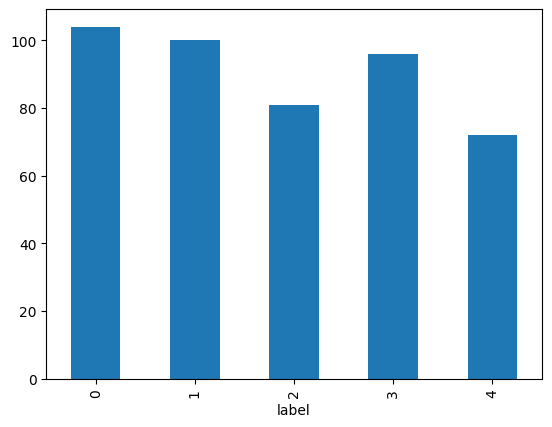

453

In [ ]:
# prompt: matplotlib 으로 barchart를 그리는 방법
import matplotlib.pyplot as plt

df.groupby('label').size().plot(kind='bar')
plt.show()

#df_B = df[df['label'] == 'B']
#df_A = df[df['label'] == 'A']
#df_N = df[df['label'] == 'N']
#df_T = df[df['label'] == 'T']
#df_C = df[df['label'] == 'C']

len(df)

In [ ]:
# tokenize
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer

#print("sklearn version is", sklearn.__version__)
tokenizer = Okt()

#전체 데이터에 대한 tf-idf를 구하려면 아래 코드 실행
true_corpus = " ".join(df['text'].values)

#df_B_corpus = " ".join(df_B['text'].values)
#df_A_corpus = " ".join(df_A['text'].values)
#df_N_corpus = " ".join(df_N['text'].values)
#df_T_corpus = " ".join(df_T['text'].values)
#df_C_corpus = " ".join(df_C['text'].values)
#print(df_B_corpus)
#print(df_N_corpus)

#tfidf_vector = TfidfVectorizer(tokenizer=tokenizer.nouns, min_df=2).fit([df_B_corpus, df_A_corpus, df_N_corpus, df_T_corpus, df_C_corpus])
#tfidf_result = tfidf_vector.transform([df_B_corpus, df_A_corpus, df_N_corpus, df_T_corpus, df_C_corpus])

tfidf_vector = TfidfVectorizer(tokenizer=tokenizer.nouns, min_df=1).fit([true_corpus])
tfidf_result = tfidf_vector.transform([true_corpus])
#print(tfidf_result)
#vocab = tfidf_vector.vocabulary_
vocab = tfidf_vector.get_feature_names_out()
print("vocab[:10] for debugging \n", vocab[:10])
len(vocab)
vocab.shape

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


vocab[:10] for debugging 
 ['가게' '가격' '가격표' '가면' '가요' '가장' '가전제품' '가지' '각' '각오']


(874,)

In [ ]:
# tfidf
i = 0
tfidf_words = tfidf_result.toarray().argsort()
#for i in range(5):
#    print(tfidf_words[i])  # tokens
#    print(len(tfidf_words[i]))

#tfidf_words[0] : true_corpus의 tf-idf 결과
#tfidf_words[1] : false_corpus의 tf-idf 결과
true_words = tfidf_words[0][::-1]  # reverse order
print ('true_words[:10] are ', true_words[:10])

for word_index in true_words[:10]:
    print(vocab[word_index])

print(len(vocab)) # 총 vocab 은 874개

true_words[:10] are  [113 430 581 675  39  49 827 549 868 176]
그
수
이
제품
것
결정
프로젝트
우리
회사
다른
874


In [ ]:
real_true_words = []

for word_index in true_words:
  word = vocab[word_index]
  if len(word) >= 2:
    real_true_words.append(word)

print(len(real_true_words))
#real_true_words = real_true_words[:500]
print('real_true_words[:20] are ', real_true_words[:20]) # 874개 vocab 중 2글자 이상의 vocab은 750개

750
real_true_words[:20] are  ['제품', '결정', '프로젝트', '우리', '회사', '다른', '계약', '대한', '비교', '제안', '저희', '예산', '비용', '만료', '권한', '관심', '가격', '기간', '위해', '이번']


### 3) tokenization and train/test data split

In [ ]:
from konlpy.tag import Okt

#print("sklearn version is", sklearn.__version__)
tokenizer = Okt()

# tokenizing nouns only
df['tokens'] = df['text'].apply(tokenizer.nouns)

# tokenize 이후에 df['tokens'] 컬럼이 empty인 행이 생겨버려, 이를 삭제해야함
#df = df.dropna(subset=['tokens'], inplace=True)
#df = df.dropna(subset=['tokens'])
print(df.iloc[417])
#print(df['tokens'][417:418].dtype)
#print(df['tokens'].dropna())

#print([df['tokens'].values][417:418] == [])
#print(df['tokens'].values == [])

#df = df.dropna(subset=['tokens'].values)
#df['tokens'][417:418] == []
#print(df['tokens'][417:418].values)
#print(len(df['tokens']))

#for i in range(len(df)):
#    if df['tokens'][i] == []:
#        #print(i, df.iloc[i], ' is null')
#        print(i, df.index[i], ' is null')
#        df = df.drop(df.index[i])
print(len(df))
# print(df[len(df['tokens'][417]) == 0])

#print(len(df['tokens'][i]))
#print(df['tokens'].isnull().sum())
#df['tokens'].str.strip()
#print(df['tokens'][417:418])
#df#['tokens'][417]

id                   418
label                  2
text      다른데도 알아봐야 겠습니다
tokens                []
Name: 417, dtype: object
453


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

prep_df = df[['tokens', 'label']]
X = pd.DataFrame(prep_df.tokens, columns=['tokens'])
y = pd.DataFrame(prep_df.label, columns=['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [ ]:
#print(X_train[:5])
#print(X_test[:5])
#print(y_train['label'])
#print(y_test[:5])

In [ ]:
# sample for train_test_split with iris data
'''
done from here
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

prep_df = df[['tokens', 'label']]
#print(iris_data.DESCR)
X = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
y = pd.DataFrame(iris_data.target, columns=['class'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
to here
'''

model = DecisionTreeClassifier(max_depth=4)
model.fit(X_train, y_train)
model.predict(X_test)
model.score(X_test, y_test)
importances = model.feature_importances_
print(importances)

indices_sorted = np.argsort(importances)

plt.figure()
plt.title("Feature importances")
plt.bar(range(len(importances)), importances[indices_sorted])
plt.xticks(range(len(importances)), X.columns[indices_sorted], rotation=90)
plt.show()

ValueError: ignored

### 4) word2vec model

In [ ]:
# skip-gram model
from gensim.models import Word2Vec
# 파라메터 설명(https://radimrehurek.com/gensim/models/word2vec.html)
#sentences : 학습에 사용될 문장들 혹은 토크나이징 된 문장들
#vector_size : 벡터의 차원(크기)
#window : 모델이 단어의 관계성을 따지는 window 크기
#min_count : 이 횟수 이하로 언급된 단어는 제외함
#sg : 1일 때 skip-gram, 그 외에는 CBOW
skipgram_model = Word2Vec(sentences = X_train['tokens'], vector_size = 30, window = 5, min_count = 3, sg = 1)  # default alpha = 0.025
skipgram_model.wv.similar_by_word('예산')

[('그것', 0.724878191947937),
 ('우리', 0.6661756634712219),
 ('월', 0.6355506181716919),
 ('당사', 0.621281623840332),
 ('귀사', 0.6127626299858093),
 ('결정', 0.5959326028823853),
 ('니즈', 0.5937116742134094),
 ('요금', 0.5844009518623352),
 ('데', 0.5764356851577759),
 ('이', 0.5687055587768555)]

### from here ...

In [ ]:
# preparation of training data
from sklearn.tree import DecisionTreeClassifier
import numpy as np

model = skipgram_model
#print(X_train['tokens'].values)
print(len(X_train['tokens'].values))

train_avg_vectors = []
for tokens in X_train['tokens'].values:
    if not tokens:
        continue
    else:
        #print(tokens)
        vecs = []
        for word in tokens:
            if word in model.wv.key_to_index.keys():
                #print(word)
                vecs.append(model.wv.get_vector(word))
        train_avg_vectors.append(np.mean(vecs, axis=0))
#train_avg_vectors = np.array(train_avg_vectors, dtype=float)
train_avg_vectors = np.array(train_avg_vectors)
#print(np.isnan(train_avg_vectors))
print(train_avg_vectors.shape)

361
(361,)


<ipython-input-70-14291dbf178f>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_avg_vectors = np.array(train_avg_vectors)


In [ ]:
# preparation of test data
test_avg_vectors = []
for tokens in X_test['tokens'].values:
    vecs = []
    for word in tokens:
        if word in model.wv.key_to_index.keys():
            #print(word)
            vecs.append(model.wv.get_vector(word))
    test_avg_vectors.append(np.mean(vecs, axis=0))

test_avg_vectors = np.array(test_avg_vectors)
test_avg_vectors.shape

<ipython-input-81-74a2b612fc38>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_avg_vectors = np.array(test_avg_vectors)


(91,)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np

n_fold = 5
n_class = 5

cv = StratifiedKFold(n_splits=n_fold, shuffle=True)
#print(X_train, y_train)
#print(cv.split(train_avg_vectors, y_train['label']), 1)

p = np.zeros((X_train.shape[0], n_class))
p_tst = np.zeros((X_test.shape[0], n_class))
print(y_train.shape)
#print(X_test.shape)

#for i_cv, (i_trn, i_val) in enumerate(cv.split(train_avg_vectors, y_train['label']), 1):
#    clf = DecisionTreeClassifier(min_samples_split=50)
#    clf.fit(train_avg_vectors[i_trn], np.array(y_train['label'][i_trn]))
#    p[i_val, :] = clf.predict_proba(train_avg_vectors[i_val])
#    p_tst += clf.predict_proba(test_avg_vectors) / n_class #테스트 셋에 대해서도 예측
#    print(f"Fold {i_cv} complete")

#print(f'Accuracy (CV): {accuracy_score(envData.label.values, np.argmax(p, axis=1)) * 100}%')
#print(f'Accuracy (test): {accuracy_score(envTestData.label.values, np.argmax(p_tst, axis=1)) * 100}%')


(362, 1)


### to here ...

In [ ]:
# skipgram_model.wv.get_vector('예산')

In [ ]:
# CBOW(continuous bag of words) model
#cbow_model = Word2Vec(sentences = X_train['tokens'], vector_size = 30, window = 5, min_count = 5, sg = 0)
#cbow_model.wv.similar_by_word('예산')

### 5) pre-training

In [ ]:
# pretraining model
import gensim
#print(gensim.__version__)
#pre_model = Word2Vec.load('/content/drive/MyDrive/Colab Notebooks/nlp/kyobonlp/ko.bin')
pre_model_df = pd.read_table('/content/drive/MyDrive/Colab Notebooks/nlp/kyobonlp/ratings.txt')
#pre_model_df  # id\t document\t label

pre_model_df['document'] = pre_model_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]"," ")
pre_model_df['document'] = pre_model_df['document'].str.replace(" +"," ")
#pre_model_df#['documet']


# tokenizing nouns only
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer

tokenizer = Okt()
pre_model_df['tokens'] = pre_model_df['document'].astype(str).apply(tokenizer.nouns)
#print(pre_model_df#['tokens'])
pre_model_df

<ipython-input-9-22cde12170ff>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  pre_model_df['document'] = pre_model_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]"," ")
<ipython-input-9-22cde12170ff>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  pre_model_df['document'] = pre_model_df['document'].str.replace(" +"," ")


,id,document,label,tokens
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1,"[때, 보고, 지금, 다시]"
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1,"[디자인, 학생, 외국, 디자이너, 그, 일군, 전통, 통해, 발전, 문화, 산업,..."
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1,"[폴리스스토리, 시리즈, 부터, 뉴, 하나, 최고]"
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1,"[연기, 진짜, 개, 생각, 몰입, 진짜, 영화]"
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1,"[안개, 밤하늘, 초승달, 영화]"
...,...,...,...,...
199995,8963373,포켓 몬스터 짜가 ㅡㅡ,0,"[포켓, 몬스터]"
199996,3302770,쓰 레 기,0,"[레, 기]"
199997,5458175,완전 사이코영화 마지막은 더욱더 이 영화의질을 떨어트린다,0,"[완전, 사이코, 영화, 마지막, 더욱더, 이, 영화, 질, 트, 린다]"
199998,6908648,왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ,0,"[왜, 라따뚜이, 스머프, 런가]"


In [ ]:
# ratings.txt로 1차 모델을 학습
from gensim.models import Word2Vec
pre_skipgram_model = Word2Vec(sentences = pre_model_df['tokens'], vector_size = 30, window = 5, min_count = 3, sg = 1, alpha=0.025, min_alpha=0.001)

# 저장하기
pre_skipgram_model.save("pre_skipgram_w2v.model")
# 불러오기
#model = Word2Vec.load("pre_skipgram_w2v.model")

pre_skipgram_model.wv.similar_by_word('예산')

[('독립영화', 0.880965530872345),
 ('단편영화', 0.8746145367622375),
 ('안목', 0.8740411400794983),
 ('저예산영화', 0.8689018487930298),
 ('이정', 0.8667644262313843),
 ('비급', 0.8643173575401306),
 ('결과물', 0.8608487844467163),
 ('급', 0.8505680561065674),
 ('따름', 0.8459652066230774),
 ('성인영화', 0.837454617023468)]

In [ ]:
# 추가학습
pre_skipgram_model_cs = Word2Vec.load("pre_skipgram_w2v.model")
#pre_skipgram_model_cs.train(df['tokens'].values, epochs=30, total_examples=len(df))
pre_skipgram_model_cs = Word2Vec(sentences = pre_model_df['tokens'], vector_size = 30, window = 5, min_count = 3, sg = 1, alpha=0.025, min_alpha=0.001, epochs=30)
pre_skipgram_model_cs.wv.similar_by_word('예산')

[('독립영화', 0.8155103921890259),
 ('투자', 0.8036372065544128),
 ('제작비', 0.799496054649353),
 ('블록버스터', 0.7896822094917297),
 ('단편영화', 0.7807205319404602),
 ('감안', 0.7609207630157471),
 ('저예산영화', 0.7557230591773987),
 ('볼케이노', 0.7519950270652771),
 ('비디오영화', 0.740166187286377),
 ('스릴러물', 0.7352980971336365)]

### 6) 시각화

In [ ]:
# 시각화 테스트용
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

#한글 폰트 지정
plt.rc('font', family='NanumBarunGothic')

model = pre_skipgram_model  #pre_model

#환경 단어 500개, 환경이 아닌 단어 500개를 불러와서, 모델을 통해 vector로 변환
#test_set = (set(real_true_words[:500])) & set(model.wv.key_to_index.keys())
#print(len(real_true_words))
#print(len(model.wv.key_to_index.keys()))
#test_set = (set(real_true_words)) & set(model.wv.key_to_index.keys())
#print(len(test_set))
#test_words = list(test_set)

test_words = list((set(real_true_words)) & set(model.wv.key_to_index.keys()))
vecs = np.array([model.wv.get_vector(word) for word in test_words])

#T-SNE 모델을 가져와서, 각 단어 벡터를 (x,y)축의 2차원으로 변환
tsne_model = TSNE(n_components=2)
transformed = tsne_model.fit_transform(vecs)
xs = transformed[:,0]
ys = transformed[:,1]



[[  5.0466385 -12.6763315]
 [ 22.007505   -1.870693 ]
 [ 15.813122   -3.9015465]
 ...
 [ -8.787548    9.15671  ]
 [-14.921076   10.454142 ]
 [  4.265592   -5.7466946]]


In [ ]:
# t-SNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

#한글 폰트 지정
plt.rc('font', family='NanumBarunGothic')

model = pre_skipgram_model #skipgram_model cbow_model pre_skipgram_model

#500 words to vector
#test_words = list((set(real_true_words[:500] + real_false_words[:500])) & set(model.wv.vocab.keys()))
test_set = (set(real_true_words)) & set(model.wv.key_to_index.keys())
test_words = list(test_set)

vecs = np.array([model.wv.get_vector(word) for word in test_words])
#print(vecs)

#T-SNE 모델을 가져와서, 각 단어 벡터를 (x,y)축의 2차원으로 변환
tsne_model = TSNE(learning_rate=100)
transformed = tsne_model.fit_transform(vecs)
xs = transformed[:,0]
ys = transformed[:,1]

#그래프에 흰색으로 점찍기
plt.figure(figsize=(20,20))
plt.scatter(xs, ys, c='w')

for idx, (x, y) in enumerate(transformed):
    #단어 찾기
    word = test_words[idx]
    #print(idx, x, y, word)

    #단어의 색깔 지정
    font_color = 'black'
    if word in real_true_words[:300]:
        font_color = 'b'
    #else:
    #    font_color = 'r'
#    elif word in real_false_words[:300]:
#        font_color = 'r'

    #(x,y)자리에 단어 표기
    plt.annotate(word, (x, y), fontsize=12, c=font_color)

plt.savefig("pre_model.png")
plt.show()

### 7) 실습; word2vec + decision tree

a. 환경 설정
b. data load
c. 한글 전처리
d. tokenization
e. word2vec; one-hot encoding, word2vec average embedding

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np

In [ ]:
model = pre_skipgram_model

train_avg_vectors = []
for tokens in df['tokens'].values:
    vecs = []
    for word in tokens:
        if word in model.wv.key_to_index.keys():
            vecs.append(model.wv.get_vector(word))
    train_avg_vectors.append(np.mean(vecs, axis=0))

#np.array(train_avg_vectors).shape
train_avg_vectors = np.array(train_avg_vectors)
train_avg_vectors.shape

<ipython-input-47-d661c825959d>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_avg_vectors = np.array(train_avg_vectors)


(453,)

In [ ]:
# 테스트셋도 동일하게 임베딩
#데이터 로드
testData = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/nlp/kyobonlp/test_set.xls")

#전처리
testData['text'] = testData['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]"," ")
testData['text'] = testData['text'].str.replace(" +"," ")

#토크나이징
testData['tokens'] = testData['text'].astype(str).apply(tokenizer.nouns)

test_avg_vectors = []
for tokens in testData['tokens'].values:
    vecs = []
    for word in tokens:
        if word in model.wv.key_to_index.keys():
            vecs.append(model.wv.get_vector(word))
    test_avg_vectors.append(np.mean(vecs, axis=0))

test_avg_vectors = np.array(test_avg_vectors)
test_avg_vectors.shape

<ipython-input-64-3f75024ea24b>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  testData['text'] = testData['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]"," ")
<ipython-input-64-3f75024ea24b>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  testData['text'] = testData['text'].str.replace(" +"," ")
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-64-3f75024ea24b>:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creati

(467,)

In [ ]:
testData = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/nlp/kyobonlp/test_set.xls")

testData['text'] = testData['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]"," ")
testData['text'] = testData['text'].str.replace(" +"," ")

testData['tokens'] = testData['text'].astype(str).apply(tokenizer.nouns)

#test_avg_vectors = []

testData['tokens'].values

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

n_fold = 5
n_class = 5

cv = StratifiedKFold(n_splits=n_fold, shuffle=True)

In [ ]:
p = np.zeros((df.shape[0], n_class))
p_tst = np.zeros((testData.shape[0], n_class))

for i_cv, (i_trn, i_val) in enumerate(cv.split(train_avg_vectors, df['label']), 1):
    clf = DecisionTreeClassifier(min_samples_split=50)
    clf.fit(train_avg_vectors[i_trn], df['label'][i_trn])
    p[i_val, :] = clf.predict_proba(train_avg_vectors[i_val])
    p_tst += clf.predict_proba(test_avg_vectors) / n_class #테스트 셋에 대해서도 예측
    print(f"Fold {i_cv} complete")

print(f'Accuracy (CV): {accuracy_score(df.label.values, np.argmax(p, axis=1)) * 100}%')
print(f'Accuracy (test): {accuracy_score(testData.label.values, np.argmax(p_tst, axis=1)) * 100}%')

ValueError: ignored

## 교보생명 word2vec by gensim
(참고; 딥 러닝을 이용한 자연어 처리 입문 https://wikidocs.net/book/2155 )


In [27]:
# 한국어 위키 덤프 데이터; 사전 학습용
from Korpora import Korpora

kowikitext = Korpora.load('kowikitext')

# # or
# Korpora.fetch('kowikitext')
print(kowikitext)


    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : Hyunjoong Kim lovit@github
    Repository : https://github.com/lovit/kowikitext
    References :

    한국어 위키피디아의 덤프 데이터를 바탕을 제작한 wikitext 형식의 텍스트 파일입니다.
    학습 및 평가를 위하여 위키페이지 별로 train (99%), dev (0.5%), test (0.5%) 로 나뉘어져있습니다.


    # License
    CC-BY-SA 3.0 which kowiki dump dataset is licensed

[Korpora] Corpus `kowikitext` is already installed at /root/Korpora/kowikitext/kowikitext_20200920.train.zip
[Korpora] Corpus `kowikitext` is already installed at /root/Korpora/kowikitext/kowikitext_20200920.train
[Korpora] Corpus `kowikitext` is already installed at /root/Korpora/kowikitext/kowikitext_20200920.test.zip
[Korpora] Corpus `kowikitext` is already installed at /root/Korpora/kowikitext/kowikitext_20200920.test


In [38]:
# kowiki_train_data = kowikitext.train[:].text
# kowikitext.dev[0]
# kowiki = kowikitext.train[:]
kowikitext.get_all_texts()[:5]
# kowikitext.get_all_pairs()  # fail

# for i in range(len(kowiki)):
#     print(kowiki[i])
#     kowiki[i] = kowiki[i].replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]"," ")
#     kowiki[i] = kowiki[i].replace(" +"," ")

# print(kowiki_train_data[:10])

['스폴리아텔레(, )는 이탈리아의 후식으로서 모양은 프랑스의 과자인 마들렌처럼 조개 모양이거나 긴 뿔 모양이기도 하다. 단어 "sfogliatelle"는  "많은 잎 혹은 층"을 의미하며 질감 자체가 여러 잎을 쌓아놓고 씹어먹는 듯한 바삭거리는 느낌이 있기 때문에 이 용어가 아주 잘 어울린다고 보기도 한다.\n산타 로사라고 부르는 스폴리아텔레의 일종은 17세기 콩가 데이 마리니에서 생겨난 과자이다.\n만들 때에는 반죽을 길고 얇게 만든 다음 쇼트닝을 두텁게 바른다. 다음으로는 계속 밀대에 반죽을 밀어서 롤처럼 만들 수 있게 반죽을 풍성하게 만든다. 가운데는 나중에 제거해서 다른 속을 채우도록 한다. 오렌지 맛이 나는 리코타 치즈를 넣기도 한다. 시트론이나 레몬 같은 과일을 넣기도 한다..\n스폴리아텔레는 이탈리아의 나폴리에서 유래했으며 굉장히 만드는 데 시간이 많이 들기 때문에 수녀원 등지에서 형태가 생겨났다고 보고 있다.',
 '나폴리에서는  "sfogliatella riccia" 로 불리며 몰타에서는 세이보리를 속으로 채워넣어서 만들기도 한다. 몰타 사람들은 이런 형태의 스폴리아텔레를 "Ricotta Pastizzi"라고 부른다. 단 맛이 안나는 세이보리가 재료인 것이 특징인데 다른 종류인 "Pastizzi tal-Pizelli"는 같은 모양이지만 세이보리 열매나 새싹을 집어 넣는다. 이 반죽을 "Ta L-Isfoll"라고 칭한다.',
 '',
 '예술',
 '뎨산 구(, )는 중국 광시 좡족 자치구 우저우 시의 현급 행정구역이다. 넓이는 313km2이고, 인구는 2007년 기준으로 190,000명이다.']

In [ ]:
## setting debug mode on
# %pdb off

Automatic pdb calling has been turned OFF


In [1]:
import pandas as pd
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt
from sklearn.preprocessing import LabelEncoder

#import matplotlib.pyplot as plt
#import urllib.request

train_data = pd.read_excel("/content/drive/MyDrive/nlp/kyobonlp/kyobodata.xls")

# preprocess; 1) drop null data, 2) exclude special symbols, 3) label encoding (into numeric-value)

# 1) drop null data
# print(train_data.isnull().sum())
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
# print(train_data.isnull().values.any())
# len(train_data)

# 2) exclude special symbols
train_data['text'] = train_data['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]"," ")
train_data['text'] = train_data['text'].str.replace(" +"," ")

# 3) label encoding
lbl = LabelEncoder()
lbl = lbl.fit(train_data['label'])
train_data['label'] = lbl.transform(train_data['label'])

train_data[:5]

<ipython-input-1-79e271048147>:20: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['text'] = train_data['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]"," ")
<ipython-input-1-79e271048147>:21: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['text'] = train_data['text'].str.replace(" +"," ")


,id,label,text
0,1,1,올해에는 많은 부서들이 예산보다 초과 지출했다
1,2,1,그 사업을 위한 예산으로 억원이 책정되어 있다
2,3,1,우리는 예산이 아주 빠듯하다
3,4,1,그 부서의 예산은 손댈 수 없다
4,5,1,우리가 올해는 예산보다 돈을 덜 썼다


In [2]:
from tqdm import tqdm
import ipdb  # ; ipdb.set_trace()

# 4) tokenization, stemming + remove stop words
# stop words definition
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
tokenizer = Okt()
tokenized_data = []

for sentence in tqdm(train_data['text']):
    # ipdb.set_trace()
    tokenized_sentence = tokenizer.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)
    # print("stopwords_removed_sentence : ", stopwords_removed_sentence)

train_data['tokens'] = tokenized_data
# train_data.iloc[410:]

100%|██████████| 453/453 [00:25<00:00, 17.95it/s] 


In [ ]:
# 명사별 토큰화 작업; 불용어 처리를 하지 않고, 명사로만 토큰화 할 경우 사용
# df = train_data
# df['tokens'] = df['text'].apply(tokenizer.nouns)

# print(train_data[:5])

토큰의 최대 길이 : 30
토큰의 평균 길이 : 9.838852097130243


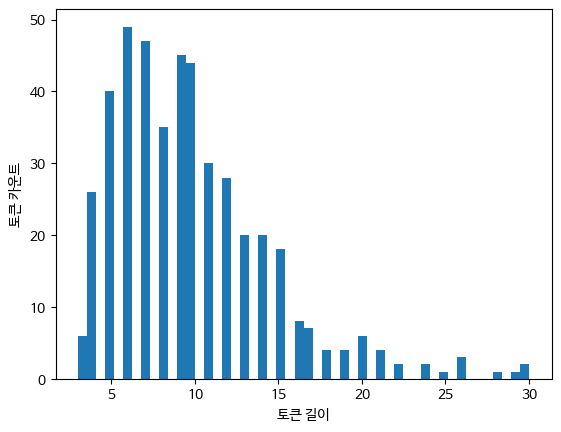

In [3]:
# 길이 분포 시각화 확인
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

print('토큰의 최대 길이 :',max(len(tokens) for tokens in tokenized_data))
print('토큰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(tokens) for tokens in tokenized_data], bins=50)
plt.xlabel('토큰 길이')
plt.ylabel('토큰 카운트')
plt.show()

In [ ]:
# pre-trained model
import gensim
# from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# unsuccessful due to version difference between gensim==3.8.3 and gensim==4.0
# ko_model = gensim.models.Word2Vec.load('./model/ko/ko.bin')
# ko_model = gensim.models.Word2Vec.load('/content/drive/MyDrive/nlp/kyobonlp/ko.bin')
# ko_model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/nlp/kyobonlp/ko.bin', binary=False, encoding='utf-8')
# ko_model = Word2Vec.load('/content/drive/MyDrive/nlp/kyobonlp/cc.ko.300.bin')
# ko_model = Word2Vec.load('/content/drive/MyDrive/nlp/kyobonlp/ko.bin')

In [4]:
# 5) word-to-vec embedding; skip-gram model
from gensim.models import Word2Vec
# 파라메터 설명(https://radimrehurek.com/gensim/models/word2vec.html)
#sentences : 학습에 사용될 문장들 혹은 토크나이징 된 문장들
#vector_size : 벡터의 차원(크기)
#window : 모델이 단어의 관계성을 따지는 window 크기
#min_count : 이 횟수 이하로 언급된 단어는 제외함
#sg : 1일 때 skip-gram, 그 외에는 CBOW
model = Word2Vec(sentences = train_data['tokens'], vector_size = 30, window = 5, min_count = 3, sg = 0)  # default alpha = 0.025

In [ ]:
# model.wv.vectors.shape
# model.wv.similar_by_word('예산')
# ipdb.set_trace()

<ipython-input-5-e97f325d306c>:40: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig("pre_model.png")
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


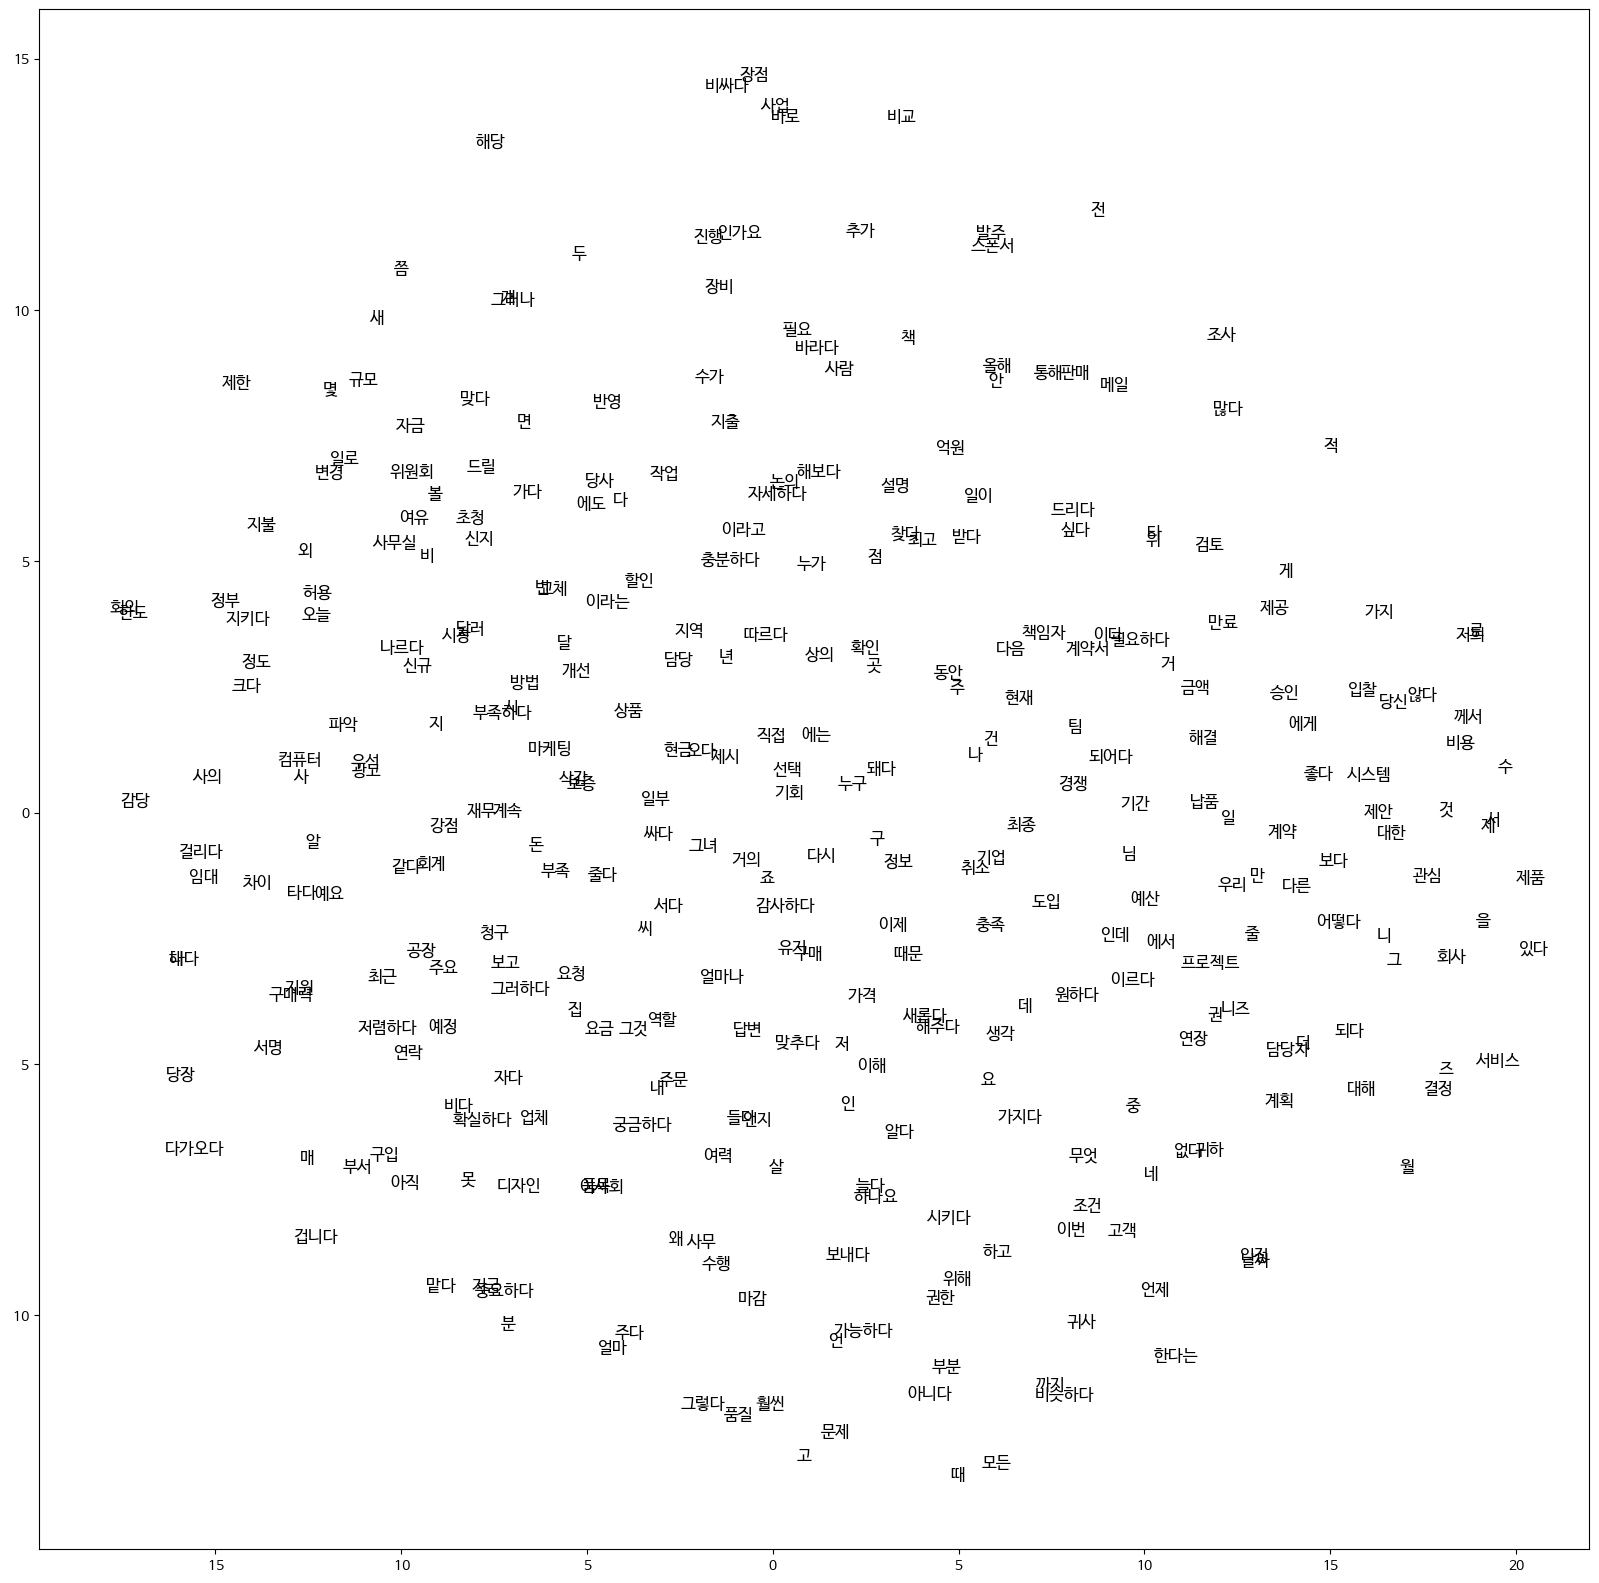

In [5]:
# embedding visualization; t-SNE
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

#한글 폰트 지정
plt.rc('font', family='NanumBarunGothic')

# model = pre_skipgram_model  #pre_model

test_words = list(model.wv.key_to_index.keys())
vecs = np.array([model.wv.get_vector(word) for word in test_words])

#T-SNE 모델을 가져와서, 각 단어 벡터를 (x,y)축의 2차원으로 변환
tsne_model = TSNE(learning_rate=100)
transformed = tsne_model.fit_transform(vecs)

xs = transformed[:,0]
ys = transformed[:,1]

#그래프에 흰색으로 점찍기
plt.figure(figsize=(20,20))
plt.scatter(xs, ys, c='w')

for idx, (x, y) in enumerate(transformed):
    #단어 찾기
    word = test_words[idx]
    # print(idx, x, y, word)

    #단어의 색깔 지정
    font_color = 'black'
    # if word in real_true_words[:300]:
    #     font_color = 'b'
    # elif word in real_false_words[:300]:
    #     font_color = 'r'

    #(x,y)자리에 단어 표기
    plt.annotate(word, (x, y), fontsize=12, c=font_color)

plt.savefig("pre_model.png")
plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


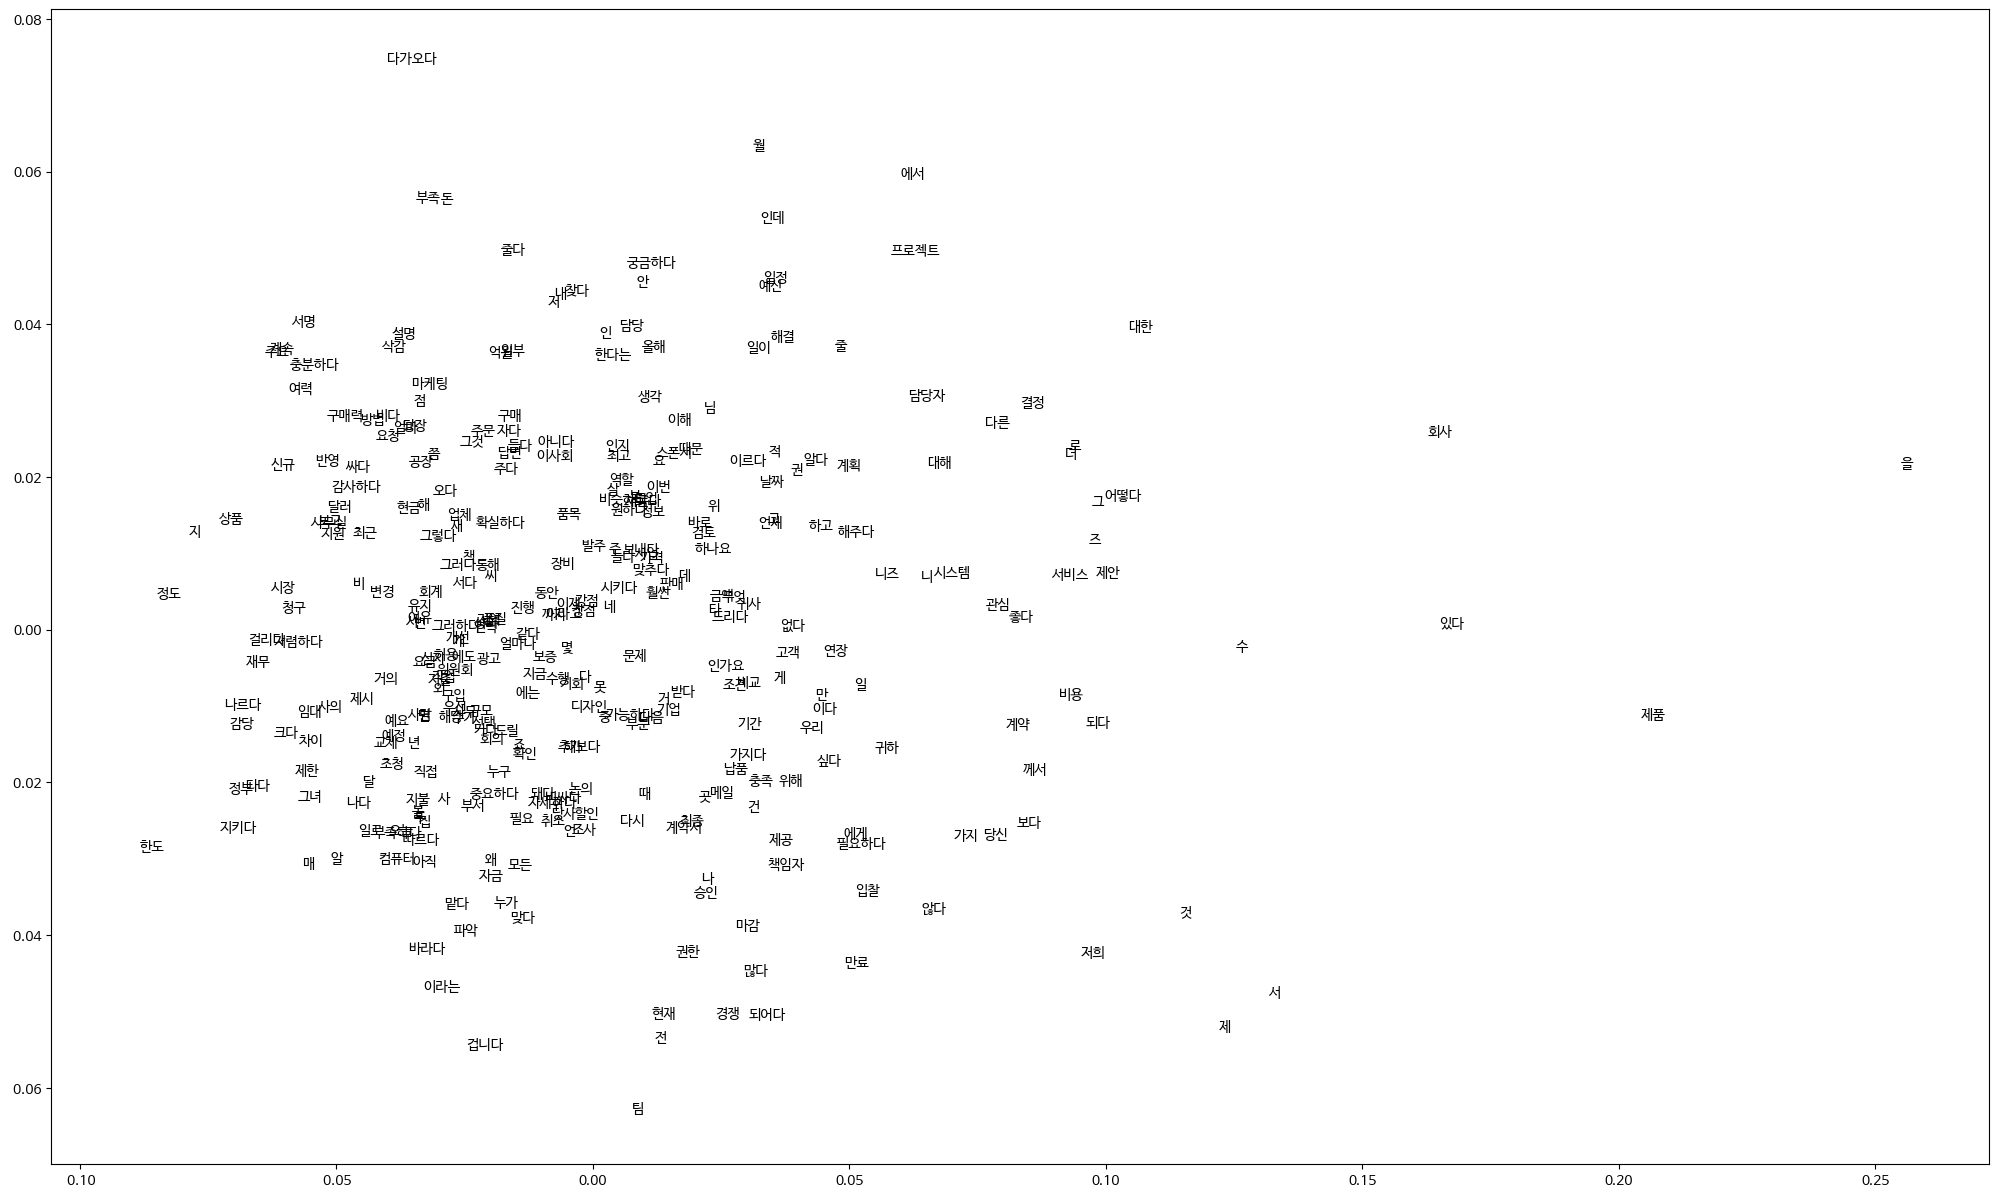

In [6]:
# embedding visualization; PCA
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

test_words = list(model.wv.key_to_index.keys())
vecs = np.array([model.wv.get_vector(word) for word in test_words])

pca = PCA(n_components=2)
xys = pca.fit_transform(vecs)
xs = xys[:, 0]
ys = xys[:, 1]

def plot_2d_graph(vocabs, xs, ys):
    plt.figure(figsize=(25, 15))
    plt.scatter(xs, ys, c='w')
    for idx, (x, y) in enumerate(vocabs):
        #단어 찾기
        word = test_words[idx]
        font_color = 'black'
        plt.annotate(word, (x, y))

plot_2d_graph(xys, xs, ys)

# comment

* word2vec은 자연어 처리의 기본 개념을 파악하는데 도움이 되지만, 단어의 순서를 고려하지 않으므로, 출현하는 단어가 같으면 의미가 반대여도 유사하다고 판단할 수 있음. 즉, 성능면에서 좋은 방법은 아님
* labeled test data가 없어, test data에 대한 평가를 할 수 없음
* 보다비에서 정답 데이터가 [label, text]의 형태로 오면 평가를 할 수 있을 듯
* 학습을 위한 데이터 양이 너무 적음
* 기본적인 개념이 파악되면, doc2vec, kobert 등 다른 방법을 시도해 보는 것이 좋겠음



